## Connection

In [4]:
import sys
sys.path.append('/home/miguelcosta/Desktop/PBL-HGO')

In [5]:
import pandas as pd
# import pandasql as ps
#import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from src.db.connection import *
from src.modelling_pipelines.final_model_pipeline import *
from src.modelling_pipelines.modelling_functions.xgboost import *


In [6]:
alertP1=connection("credentials.txt")

Tables: [(bytearray(b'ConsultaUrgencia_doentespedidosconsultaNeurologia2012'),), (bytearray(b'consultaneurologia2012'),), (bytearray(b'consultaneurologia201216anon_true'),), (bytearray(b'hgo_data_032023'),)]
267


/home/miguelcosta/Desktop/PBL-HGO/src/db/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


## Data Preparation

In [7]:
data = pre_process(alertP1)

/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [8]:
data["Texto"]

630     Doente de 71 anos de idade, com tremor acentua...
1537                                Sem relatorio clinico
985     Traz inumeros relatorios das idas ao HGO-SU po...
1103    Tremor fino de ambas as mãos e boca, desde há ...
752     PÉ PENDENTE DE INSTALAÇÃO HÁ CERCA DE 1 A 2 ME...
                              ...                        
1606    Doente que desde 2013 tem disfagia para sólido...
1335    Sra de 66 anos, seguida em Psiquiatria por doe...
1177    24A Sequelas de parto / anoxia cerebral foi se...
1332    Doente com episódios frequentes de desorientaç...
1227    Dte 79 anos com AVC HE ha 6 meses comm sequela...
Name: Texto, Length: 1609, dtype: object

In [9]:
#eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida']
#X = data.drop(eliminate_cols,axis=1)# Features

X = data.Texto
y = data.result # Target variable

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)



In [10]:
def calculate_test_loss(model, test_dataloader):
    model.eval()
    total_loss = 0
    for step,batch in enumerate(test_dataloader):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
    return total_loss / len(test_dataloader)


In [17]:
def train_biobert(X_train, y_train, epochs=10, lr=1e-5, batch_size=32):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    from torch.utils.data import TensorDataset, DataLoader, RandomSampler
    from torch.utils.tensorboard import SummaryWriter
    from transformers import AdamW

    

    # Load BioBERTpt model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('pucpr/biobertpt-all')
    model = AutoModelForSequenceClassification.from_pretrained('pucpr/biobertpt-all', num_labels=2, output_attentions=True)

    # Tokenize and encode sequences in the training set
    tokens_train = tokenizer.batch_encode_plus(
        X_train.tolist(),
        max_length = 200,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    # Convert integer sequences to tensors
    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(y_train.tolist())

    # Create data loader for training data
    train_data = TensorDataset(train_seq, train_mask, train_y)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Specify loss function (Cross-Entropy)
    optimizer = AdamW(model.parameters(), lr=lr)

    # Train model
    writer = SummaryWriter()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for step,batch in enumerate(train_dataloader):
            batch = [r.to(device) for r in batch]
            sent_id, mask, labels = batch
            optimizer.zero_grad()

            # Forward pass
            outputs = model(sent_id, mask, labels=labels)  # Pass labels to the model
            loss = outputs.loss  # Get the loss directly from the model's outputs
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Log attention weights as images
            attention_weights = outputs.attentions
            # Iterate through each batch
            for batch_idx, batch_attention in enumerate(attention_weights):
                # Iterate through each layer's attention weights
                for i, layer_attention in enumerate(batch_attention):
                    # You don't need to stack a single tensor, just keep it as is
                    stacked_attention = layer_attention  # No need to stack a single tensor
                    # Flatten the tensor to 2D
                    flattened_attention = stacked_attention.view(-1, stacked_attention.shape[-1])

                    # Add a unique batch-specific tag for each layer's attention
                    tag = f'Batch_{batch_idx}/Attention_Weights_Layer_{i}'

                    # Visualize attention weights as images
                    writer.add_image(tag, flattened_attention, dataformats='HW')

        #Metrics Tensorboard
        avg_train_loss = total_loss / len(train_dataloader)            
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        for param_group in optimizer.param_groups:
            writer.add_scalar('Learning_Rate', param_group['lr'], epoch)
        
        # Log attention weights as images
        for i, layer_attention in enumerate(attention_weights):
            writer.add_image(f'Attention_Weights_Layer_{i}', layer_attention, dataformats='HW')

        # log model parameters and gradients
        for name, param in model.named_parameters():
            writer.add_histogram('Parameters/' + name, param.data.cpu().numpy(), epoch)
            if param.grad is not None:
                writer.add_histogram('Gradients/' + name, param.grad.data.cpu().numpy(), epoch)

    writer.close()

    return model


In [18]:
model = train_biobert(X_train, y_train, epochs=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'stacked_attention' is not defined

In [12]:
def predict(model, X_test, batch_size = 32):
    from transformers import AutoTokenizer
    import torch

    # Load BioBERTpt tokenizer
    tokenizer = AutoTokenizer.from_pretrained('pucpr/biobertpt-all')

    # Tokenize and encode sequences in the test set
    tokens_test = tokenizer.batch_encode_plus(
        X_test.tolist(),
        max_length = 200,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    # Convert integer sequences to tensors
    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])

    # Create data loader for test data
    from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

    test_data = TensorDataset(test_seq, test_mask)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    preds = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for step,batch in enumerate(test_dataloader):
        batch = [t.to(device) for t in batch]
        sent_id, mask = batch
        with torch.no_grad():
            pred = model(sent_id, mask)
            preds.append(pred)
    
    return preds


In [13]:
preds = predict(model, X_test)

/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
preds

[SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0812,  0.8092],
         [ 1.8831, -1.0050],
         [ 0.2150,  0.4359],
         [-1.0382,  0.6434],
         [ 0.8696, -0.0075],
         [ 1.1693, -0.6516],
         [ 0.8639, -0.4991],
         [ 0.1194,  0.3992],
         [ 1.3570, -0.7192],
         [ 2.0653, -1.1655],
         [-1.8273,  1.5828],
         [-1.9990,  1.9769],
         [ 0.6059,  0.1989],
         [-1.4649,  1.5729],
         [-1.6705,  1.5349],
         [-0.0931,  0.1422],
         [ 1.6655, -0.9243],
         [-0.6607,  0.4908],
         [ 0.7165, -0.2906],
         [-1.1660,  1.4261],
         [ 0.7835,  0.0878],
         [ 0.8670,  0.1094],
         [-0.6066,  0.9089],
         [ 0.7082, -0.3937],
         [-0.6676,  1.0667],
         [ 2.0653, -1.1655],
         [-1.2456,  1.3133],
         [ 0.8336,  0.1210],
         [ 0.1701,  0.2947],
         [ 1.4994, -0.5748],
         [-1.5064,  1.1897],
         [-0.2484,  0.6905]]), hidden_states=None, attenti

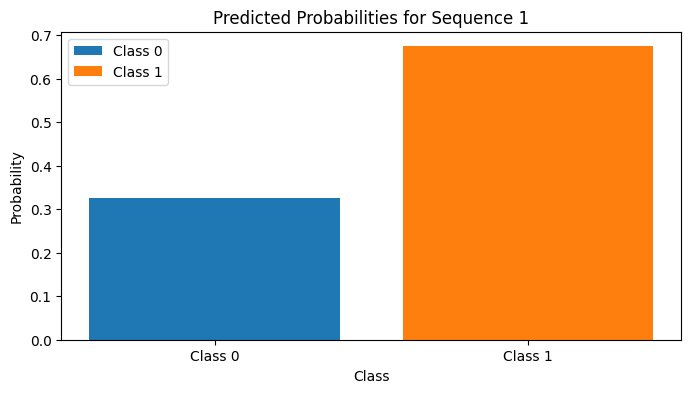

In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Extract logits and convert to probabilities using softmax
probabilities = [F.softmax(pred.logits, dim=-1).tolist()[0] for pred in preds]

# Define class labels (you can adjust these labels based on your problem)
class_labels = ['Class 0', 'Class 1']

# Create a bar plot to visualize the probabilities for each prediction
fig, ax = plt.subplots(figsize=(8, 4))
for i, label in enumerate(class_labels):
    ax.bar(i, probabilities[0][i], label=label)

# Customize the plot
ax.set_xlabel('Class')
ax.set_ylabel('Probability')
ax.set_title('Predicted Probabilities for Sequence 1')
ax.set_xticks(range(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.legend()

# Show the plot
plt.show()


In [16]:
 # Combine prediction outputs into a single tensor
all_logits = torch.cat([p.logits for p in preds], dim=0)

# Apply a threshold or softmax to get class labels or probabilities, respectively
# For binary classification, you can apply a threshold (e.g., 0.5)
predicted_labels = np.argmax(all_logits.cpu().numpy(), axis=1)  # Assuming binary classification

In [23]:
preds

[SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0812,  0.8092],
         [ 1.8831, -1.0050],
         [ 0.2150,  0.4359],
         [-1.0382,  0.6434],
         [ 0.8696, -0.0075],
         [ 1.1693, -0.6516],
         [ 0.8639, -0.4991],
         [ 0.1194,  0.3992],
         [ 1.3570, -0.7192],
         [ 2.0653, -1.1655],
         [-1.8273,  1.5828],
         [-1.9990,  1.9769],
         [ 0.6059,  0.1989],
         [-1.4649,  1.5729],
         [-1.6705,  1.5349],
         [-0.0931,  0.1422],
         [ 1.6655, -0.9243],
         [-0.6607,  0.4908],
         [ 0.7165, -0.2906],
         [-1.1660,  1.4261],
         [ 0.7835,  0.0878],
         [ 0.8670,  0.1094],
         [-0.6066,  0.9089],
         [ 0.7082, -0.3937],
         [-0.6676,  1.0667],
         [ 2.0653, -1.1655],
         [-1.2456,  1.3133],
         [ 0.8336,  0.1210],
         [ 0.1701,  0.2947],
         [ 1.4994, -0.5748],
         [-1.5064,  1.1897],
         [-0.2484,  0.6905]]), hidden_states=None, attenti

/tmp/ipykernel_106090/3362038008.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predicted_labels, palette='Set2')


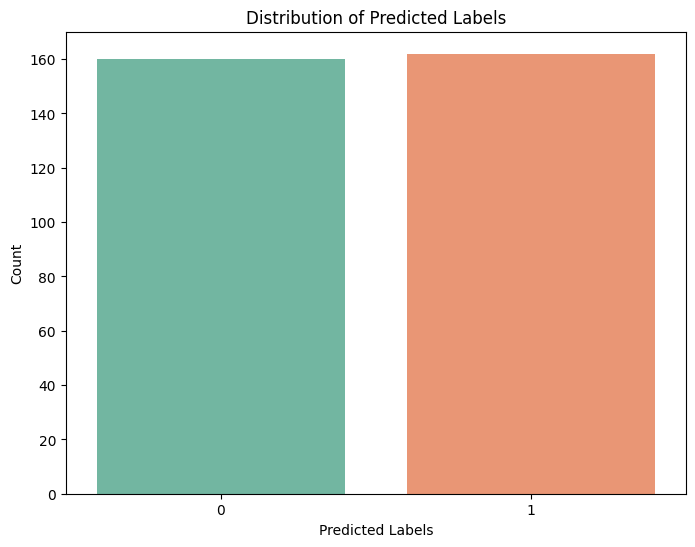

In [17]:
predicted_labels

import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(x=predicted_labels, palette='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()


In [33]:
pd.value_counts(predicted_labels)

/tmp/ipykernel_106090/2062784655.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(predicted_labels)


1    162
0    160
Name: count, dtype: int64

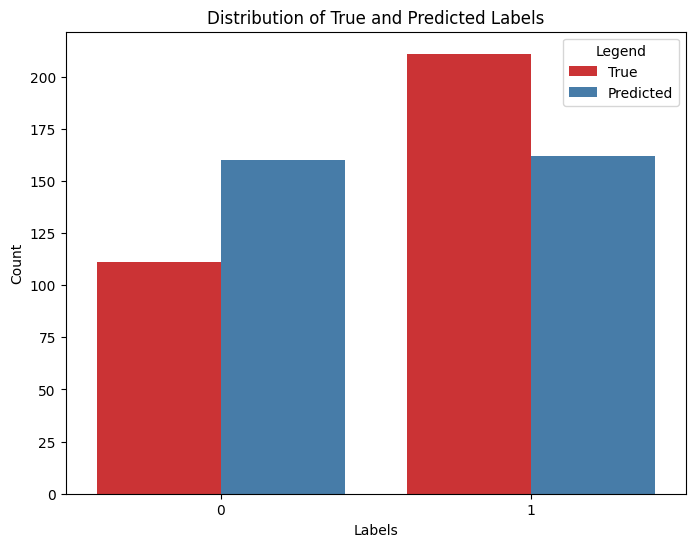

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization
df = pd.DataFrame({'Labels': np.concatenate([y_test, predicted_labels]),
                   'Type': np.repeat(['True', 'Predicted'], len(y_test))})

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Labels', hue='Type', palette='Set1')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of True and Predicted Labels')
plt.legend(title='Legend', labels=['True', 'Predicted'])
plt.show()


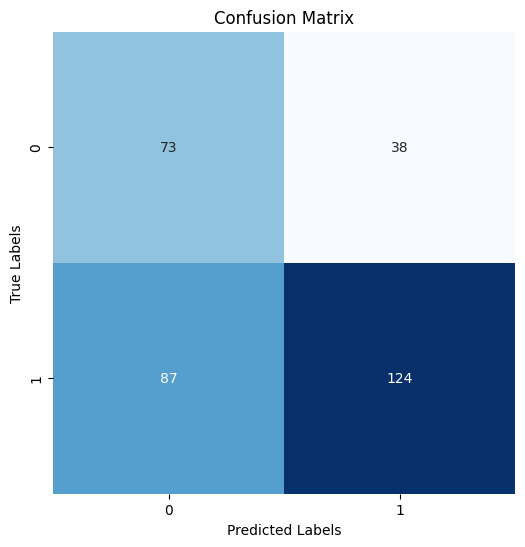

Precision: 0.7654320987654321
Recall: 0.5876777251184834


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
# Replace 'y_true' and 'y_pred' with your actual values
y_true = y_test
y_pred = predicted_labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print("Precision:", precision)
print("Recall:", recall)


In [ ]:
#Install that
#pip install tensorboard
#pip install tensorboardX
